In [77]:
'''
Analysis of /r/nba Posts
@author: Brian Lin
'''
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.optimize import minimize
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

In [78]:
def return_csv_files(path):
    pattern = r'^.*\.csv$'
    return [f for f in os.listdir(path) if bool(re.match(pattern,f))]
    
path = 'data/backlog/'
csv_files = return_csv_files(path)
df = pd.DataFrame()
for csv in csv_files:
    csv_df = pd.read_csv(path + csv)
    df = pd.concat([df,csv_df])
df['created'] = pd.to_datetime(df.created, unit = 's')

# 18,001 total examples with no duplicates

In [126]:
# top domains by value_count
top_domains = ['selfnba', 'twitter','youtube','streamable','instagram','espn','imgur','nbacom','theringer','yahoo','bleacherreport']
domain_df = pd.DataFrame()
domains = df.domain.apply(lambda d: ''.join(d.split('.')))

def strip_domain(d):
    for td in top_domains:
        if td in d:
            return td
    return 'other'


domain_df['domain'] = domains.apply(strip_domain)
domain_df['score'] = df.score
for td in top_domains:
    domain_df[td] = domains.apply(lambda d: 1 if td in d else 0)

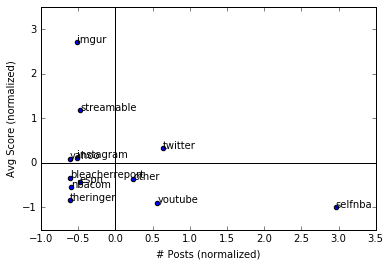

In [80]:
def normalize(column):
    mean = np.mean(column)
    sd = np.std(column)
    return column.apply(lambda d: (d-mean)/sd)

def plot_normalized_scatter(x,y,labels):
    fig, ax = plt.subplots()
    ax.scatter(x,y)
    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i],y[i]))
    plt.plot([0,0], [-5,5], color='k')
    plt.plot([5,-5], [0,0], color='k')
    plt.xlim(-1, 3.5)
    plt.ylim(-1.5, 3.5)
    plt.ylabel('Avg Score (normalized)')
    plt.xlabel('# Posts (normalized)')
    

norm_domain_df = domain_df.groupby('domain').agg({'score':[np.mean,np.size]}).apply(normalize)
x = norm_domain_df['score']['size']
y = norm_domain_df['score']['mean']
n = norm_domain_df.index

plot_normalized_scatter(x,y,n)

In [81]:
def front_page_or_not(score,flag = 0):
    # karma >= 150 = front_page, s = 1
    # 150 > karma >= 50 = iffy, s = 0.5
    # 50 > karma = not front_page, s = 0
    if score >= 150:
        return 1
    elif score >= 50:
        if flag == 1:
            return 1
        else:
            return 0.5
    else:
        return 0

front_page_ser = df.score.apply(front_page_or_not)
front_page_ser.value_counts()

0.0    10985
1.0     4407
0.5     2609
Name: score, dtype: int64

In [82]:
df.score.describe()

count    18001.000000
mean       210.539970
std        548.597572
min          0.000000
25%          6.000000
50%         27.000000
75%        144.000000
max       6296.000000
Name: score, dtype: float64

0.215622450606


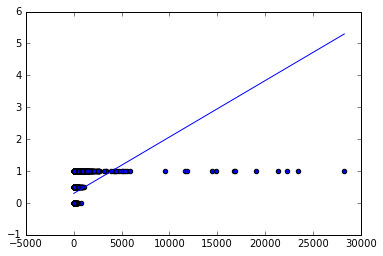

In [83]:
r = np.corrcoef(df.num_comments,front_page_ser)[0][1]
b = front_page_ser.std()/df.num_comments.std() * r
a = front_page_ser.mean() - df.num_comments.mean()*b

plt.scatter(df.num_comments, front_page_ser)
plt.plot([df.num_comments.min(),df.num_comments.max()],[df.num_comments.min()*b + a,df.num_comments.max()*b + a])
print r


In [170]:
def prediction_score(predicted_p, Y,threshold=0.5):
    def greater_than_one_half(x):
        if x > threshold:
            return 1
        else:
            return 0
        
    predicted_Y = np.array([greater_than_one_half(x) for x in predicted_p])
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(len(predicted_Y)):
        if predicted_Y[i] == 1 and Y[i] == 1:
            true_pos +=1
        elif predicted_Y[i] == 1 and Y[i] == 0:
            false_pos +=1
        elif predicted_Y[i] == 0 and Y[i] == 1:
            true_neg +=1
        elif predicted_Y[i] == 0 and Y[i] == 0:
            false_neg +=1
    
    wrong = float(np.sum(np.abs(predicted_Y - Y)))
    total = float(len(X))
    ans = dict()
    ans['accuracy'] =  1-(wrong/total)
    ans['true_pos'] = true_pos
    ans['true_neg'] = true_neg
    ans['false_pos'] = false_pos
    ans['false_neg'] = false_neg
    if true_pos == 0 and false_pos == 0:
        ans['recall'] = float(true_pos) / float((true_pos + true_neg))
    elif true_pos == 0 and true_neg == 0:
        ans['precision'] = float(true_pos) / float((true_pos + false_pos))
    else:
        ans['precision'] = float(true_pos) / float((true_pos + false_pos))
        ans['recall'] = float(true_pos) / float((true_pos + true_neg))
        ans['f1_score'] = 2 * ans['precision'] * ans['recall'] / (ans['precision'] + ans['recall'] )
    return ans

[]

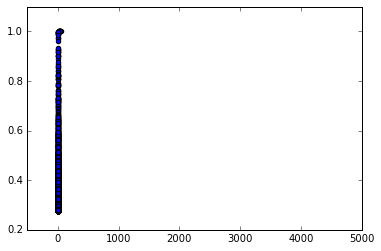

In [203]:
def front_page(score,n=150):
    if score >= n:
        return 1
    else:
        return 0

def sigmoid(z):
    return np.power(1 + np.exp(-z), -1)

def logistic_cost_regularized(theta, Xdata, Ydata, lam=1):
    # NB Xdata must be a numpy array

    m = float(len(Xdata))
    
    J = (
        - 1/m * (np.log(sigmoid(Xdata.dot(theta))).dot(Ydata) + 
        np.log(1-sigmoid(Xdata.dot(theta))).dot(1-Ydata) ) + 
        lam/(2*m) * np.sum(theta[1:] ** 2) 
        )
    if np.isnan(J):
        return(np.inf)
    return(J)

def logistic_grad_regularized(theta, Xdata, Ydata, lam=1):
    # NB Xdata must be a numpy array
    m = float(len(Xdata))
    
    grad = theta.copy() * lam
    grad[0] = 0
    grad += Xdata.T.dot(sigmoid(Xdata.dot(theta))-Ydata)
    grad *= 1/m 
    
    return grad 

X = normalize(df.num_comments)
Y = df.score.apply(front_page)
poly = PolynomialFeatures(1)
X_Transformed = poly.fit_transform(X.values.reshape(len(X),1))
Y = Y.values
theta = np.zeros((X_Transformed.shape[1],))
res = minimize(logistic_cost_regularized, theta, args=(X_Transformed,Y), method = 'Nelder-Mead', jac=logistic_grad_regularized, options={'maxiter':400})

predicted_Y = np.array(sigmoid(X_Transformed.dot(res.x)))

plt.scatter(X, sigmoid(X_Transformed.dot(res.x)))
plt.xlim(-500,5000)

plt.plot()

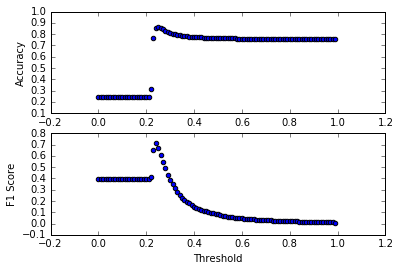

In [86]:

score_df = pd.DataFrame()
accuracy_scores_df = []
for threshold_val in np.arange(0.0,1.0,0.01):
    p_score = prediction_score(predicted_Y, Y, threshold_val)
    p_score['threshold'] = threshold_val
    accuracy_scores_df.append(p_score)
a_df = pd.DataFrame(accuracy_scores_df)

fig = plt.figure()
ax1 = fig.add_subplot(211)

ax1.scatter(x = a_df['threshold'], y=a_df['accuracy'])
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')

ax2 = fig.add_subplot(212)

ax2.scatter(x = a_df['threshold'], y=a_df['f1_score'])
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1 Score')

plt.show()

In [121]:
num_comments_logit_df =  pd.concat([pd.DataFrame(X.values, columns= ["X"]),pd.DataFrame(predicted_Y, columns= ["Y"])], axis=1)
num_comments_logit_df[num_comments_logit_df.Y > .25].sort_values(by="X").iloc[0]

X    129.000000
Y      0.250225
Name: 9100, dtype: float64

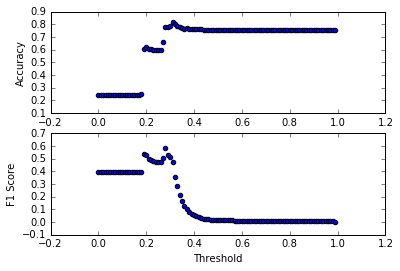

In [201]:
x_data = domain_df.iloc[:,2:]
x_data = pd.concat([x_data,df.num_comments], axis = 1)
x_data['num_comments'] = normalize(x_data['num_comments'])
Y1 = df.score.apply(front_page)
poly1 = PolynomialFeatures(1)
X_Transformed1 = poly1.fit_transform(x_data.values)

theta1 = np.zeros((X_Transformed1.shape[1],))
res1 = minimize(logistic_cost_regularized, theta1, args=(X_Transformed1,Y.values), 
                method = 'Nelder-Mead', jac=logistic_grad_regularized, options={'maxiter':400})
predicted_Y1 = np.array(sigmoid(X_Transformed1.dot(res1.x)))
accuracy_scores_df1 = []
for threshold_val in np.arange(0.0,1.0,0.01):
    p_score = prediction_score(predicted_Y1, Y1.values, threshold_val)
    p_score['threshold'] = threshold_val
    accuracy_scores_df1.append(p_score)
a_df1 = pd.DataFrame(accuracy_scores_df1)
a_df1


fig = plt.figure()
ax1 = fig.add_subplot(211)

ax1.scatter(x = a_df1['threshold'], y=a_df1['accuracy'])
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')

ax2 = fig.add_subplot(212)

ax2.scatter(x = a_df1['threshold'], y=a_df1['f1_score'])
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1 Score')

plt.show()

In [200]:
# WITH DOMAIN FEATURES
pd.concat([a_df1.iloc[a_df1.accuracy.argmax()], a_df1.iloc[a_df1.f1_score.argmax()]], axis =1)

,51,44
accuracy,0.842120,0.775735
f1_score,0.550459,0.606185
false_neg,13419.000000,10857.000000
false_pos,175.000000,2737.000000
precision,0.908616,0.531656
recall,0.394826,0.705015
threshold,0.510000,0.440000
true_neg,2667.000000,1300.000000
true_pos,1740.000000,3107.000000


In [196]:
# WITH ONLY NUM COMMENTS
# If Threshold is .25, accuracy is .86, f1_score is .66
pd.concat([a_df.iloc[a_df.accuracy.argmax()], a_df.iloc[a_df.f1_score.argmax()]], axis =1)

,25,24
accuracy,0.861674,0.857286
f1_score,0.668795,0.710600
false_neg,12997.000000,12278.000000
false_pos,597.000000,1316.000000
precision,0.808100,0.705593
recall,0.570456,0.715680
threshold,0.250000,0.240000
true_neg,1893.000000,1253.000000
true_pos,2514.000000,3154.000000
